In [463]:
### feature engineering

In [464]:
import os
import math
import warnings
import logging
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import extinction
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

warnings.filterwarnings("ignore")

In [465]:
# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

@dataclass
class Config:
    data_root: str = ""
    out_root: str = "features_out"
    splits: Tuple[int, int] = (1, 20)
    valid_filters: Tuple[str, ...] = ("u", "g", "r", "i", "z", "y")

    # Cleaning
    dropna_cols: Tuple[str, ...] = ("object_id", "Time (MJD)", "Flux", "Flux_err", "Filter")
    min_fluxerr: float = 0.0
    merge_duplicates: bool = True

    # De-extinction
    use_deextinction: bool = True

    # Time features
    snr_det_threshold: float = 3.0
    snr_strong_threshold: float = 5.0
    
    # Color features
    color_max_dt_days: float = 1.0

    # Shape fitting (NOW ENABLED!)
    do_shape_fitting: bool = True  # ⭐ FIXED: Changed to True
    shape_fit_min_points: int = 6  # Reduced from 8
    shape_fit_min_peak_snr: float = 5.0  # Reduced from 8.0
    shape_fit_per_filter: bool = True  # ⭐ NEW: Fit per filter

    # Missing handling
    do_imputation: bool = True

    # Feature selection
    do_feature_selection: bool = True  # ⭐ FIXED: Changed to True
    corr_threshold: float = 0.95
    rf_top_k: int = 150
    random_state: int = 42
    
    # Performance
    use_multiprocessing: bool = False  # Set True if on local machine
    n_jobs: int = 4

In [466]:
# =========================
# COSMOLOGY HELPERS - OPTIMIZED
# =========================

C_KM_S = 299792.458

# ⭐ NEW: Pre-computed lookup table for speed
_DL_CACHE = {}

def E_z(z: np.ndarray, Om0: float = 0.3) -> np.ndarray:
    """E(z)=H(z)/H0 for flat LCDM."""
    Ol0 = 1.0 - Om0
    return np.sqrt(Om0 * (1 + z)**3 + Ol0)

def luminosity_distance_Mpc_fast(z: np.ndarray, H0: float = 70.0, Om0: float = 0.3) -> np.ndarray:
    """
    ⭐ OPTIMIZED: Use vectorized calculation with caching
    """
    z = np.asarray(z, dtype=float)
    out = np.full_like(z, np.nan, dtype=float)
    
    mask = np.isfinite(z) & (z >= 0)
    if not mask.any():
        return out
    
    z_valid = z[mask]
    z_unique = np.unique(z_valid)
    
    # Compute for unique z values only
    for zz in z_unique:
        cache_key = f"{zz:.6f}_{H0}_{Om0}"
        
        if cache_key not in _DL_CACHE:
            if zz == 0:
                _DL_CACHE[cache_key] = 0.0
            else:
                grid = np.linspace(0.0, zz, 256)  # Reduced from 512
                integral = np.trapz(1.0 / E_z(grid, Om0=Om0), grid)
                d_c = (C_KM_S / H0) * integral
                d_l = (1.0 + zz) * d_c
                _DL_CACHE[cache_key] = d_l
        
        # Fill all matching z values
        z_mask = (z_valid == zz)
        out[np.where(mask)[0][z_mask]] = _DL_CACHE[cache_key]
    
    return out



🌌 MỤC ĐÍCH TỔNG THỂ CỦA ĐOẠN CODE

Đoạn này dùng để:

Chuyển redshift z → luminosity distance D(L)
→ từ đó:

tính độ sáng tuyệt đối : M(abs)
	​


chuẩn hóa độ sáng giữa các object ở redshift khác nhau

làm feature vật lý quan trọng cho TDE vs SN

👉 Đây là bước bắt buộc trong astronomy-aware ML, không phải trang trí.

In [467]:
def absolute_mag_from_flux_uJy(flux_uJy: np.ndarray, d_L_Mpc: np.ndarray) -> np.ndarray:
    """Convert flux to absolute magnitude."""
    flux = np.asarray(flux_uJy, dtype=float)
    dL = np.asarray(d_L_Mpc, dtype=float)
    out = np.full_like(flux, np.nan, dtype=float)

    mask = np.isfinite(flux) & (flux > 0) & np.isfinite(dL) & (dL > 0)
    if not mask.any():
        return out

    m_ab = 23.9 - 2.5 * np.log10(flux[mask])
    DM = 5.0 * np.log10(dL[mask]) + 25.0
    out[mask] = m_ab - DM
    return out

In [468]:
from extinction import fitzpatrick99
import numpy as np
import pandas as pd

def apply_deextinction_safe(df: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    """
    SAFE + CORRECT de-extinction using extinction.fitzpatrick99

    - Handles array wavelength
    - Handles scalar Av correctly (library limitation)
    - Vectorized via grouping (FAST)
    - Propagates Flux_err
    """
    if "EBV" not in df.columns:
        raise ValueError("EBV not found. Merge logs first.")

    df = df.copy()

    required_cols = {"Flux", "Flux_err", "Filter", "EBV"}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns for de-extinction: {missing}")

    # Effective wavelength per LSST filter (Angstrom)
    eff_wavelength = {
        "u": 3641.0,
        "g": 4704.0,
        "r": 6155.0,
        "i": 7504.0,
        "z": 8695.0,
        "y": 10056.0,
    }

    df["lambda_eff"] = df["Filter"].map(eff_wavelength)

    if df["lambda_eff"].isna().any():
        bad = df.loc[df["lambda_eff"].isna(), "Filter"].unique()
        raise ValueError(f"Unknown filter(s): {bad}")

    # Clamp EBV to physical range
    EBV = np.clip(df["EBV"].values.astype(float), 0.0, 1.0)
    Av = EBV * 3.1

    lam = df["lambda_eff"].values.astype(float)

    # === KEY FIX: Fitzpatrick99 only supports scalar Av ===
    A_lambda = np.zeros(len(df), dtype=float)

    for av in np.unique(Av):
        mask = Av == av
        if np.any(mask):
            A_lambda[mask] = fitzpatrick99(lam[mask], float(av))

    # De-extinction correction
    corr = 10.0 ** (A_lambda / 2.5)

    df["Flux_dered"] = df["Flux"].values * corr
    df["Flux_err_dered"] = df["Flux_err"].values * corr

    df.drop(columns="lambda_eff", inplace=True)

    return df


In [469]:
# =========================
# STATISTICAL FEATURES - ENHANCED
# =========================

def stats_features_per_filter_enhanced(df: pd.DataFrame, value_col: str, cfg: Config) -> pd.DataFrame:
    """
    ⭐ ENHANCED: Added skewness, kurtosis, MAD, amplitude
    """
    g = df.groupby(["object_id", "Filter"])[value_col]

    def mad(x):
        """Median Absolute Deviation"""
        return np.median(np.abs(x - np.median(x)))
    
    def beyond_1std(x):
        """Fraction of points beyond 1 sigma"""
        if len(x) < 3:
            return 0.0
        m = np.mean(x)
        s = np.std(x)
        return float(np.mean(np.abs(x - m) > s))

    feats = g.agg(
        mean="mean",
        std="std",
        median="median",
        min="min",
        max="max",
        q10=lambda x: np.nanpercentile(x, 10),
        q90=lambda x: np.nanpercentile(x, 90),
        # ⭐ NEW FEATURES:
        skew=lambda x: stats.skew(x, nan_policy='omit'),
        kurt=lambda x: stats.kurtosis(x, nan_policy='omit'),
        mad=mad,
        amplitude=lambda x: np.nanmax(x) - np.nanmin(x),
        beyond_1std=beyond_1std
    ).reset_index()

    # Pivot to wide
    wide = feats.pivot(index="object_id", columns="Filter")
    wide.columns = [f"{f}_{stat}_{value_col}" for stat, f in wide.columns]
    wide = wide.reset_index()
    
    return wide

In [470]:
def count_features_per_filter(df: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    """Count observations per filter."""
    g = df.groupby(["object_id", "Filter"]).size().reset_index(name="n_obs")
    wide = g.pivot(index="object_id", columns="Filter", values="n_obs")
    wide.columns = [f"n_obs_{f}" for f in wide.columns]
    wide = wide.fillna(0).reset_index()
    return wide

In [471]:
def snr_features(df: pd.DataFrame, flux_col: str, cfg: Config) -> pd.DataFrame:
    """SNR-based features."""
    out = df.copy()
    err_col = "Flux_err_dered" if flux_col == "Flux_dered" else "Flux_err"
    out["SNR"] = out[flux_col].values / out[err_col].values

    grp = out.groupby("object_id")
    feats = pd.DataFrame({
        "snr_max": grp["SNR"].max(),
        "snr_mean": grp["SNR"].mean(),
        "snr_median": grp["SNR"].median(),  # ⭐ NEW
        "snr_std": grp["SNR"].std(),
        "n_snr_gt3": grp.apply(lambda x: int(np.sum(x["SNR"].values > cfg.snr_det_threshold))),
        "n_snr_gt5": grp.apply(lambda x: int(np.sum(x["SNR"].values > cfg.snr_strong_threshold))),
        "frac_snr_gt3": grp.apply(lambda x: float(np.mean(x["SNR"].values > cfg.snr_det_threshold))),
        "frac_snr_gt5": grp.apply(lambda x: float(np.mean(x["SNR"].values > cfg.snr_strong_threshold))),
    }).reset_index()
    
    return feats

In [472]:
# =========================
# TIME-DOMAIN FEATURES - ENHANCED
# =========================
from scipy.signal import find_peaks


def overall_time_features_enhanced(df: pd.DataFrame, flux_col: str, cfg: Config) -> pd.DataFrame:
    """
    HYBRID VERSION:
    - Logic vật lý: Version B (Detection Window, Correct Error)
    - Logic toán học: Version A (Robust Slope)
    """
    
    # 1. Tự động chọn đúng cột Error (Fix lỗi vật lý của Version A)
    err_col = "Flux_err_dered" if flux_col == "Flux_dered" else "Flux_err"
    
    tmp = df.copy()
    tmp["SNR"] = tmp[flux_col].values / tmp[err_col].values

    # Hàm tính slope kháng nhiễu (Của Version A)
    def robust_rate(t, f, frac=0.2):
        if len(f) < 3: return np.nan # Cần ít nhất 3 điểm
        # Chỉ lấy top k điểm đầu và cuối để tính trung vị
        k = max(1, int(frac * len(f)))
        t1, t2 = np.median(t[:k]), np.median(t[-k:])
        f1, f2 = np.median(f[:k]), np.median(f[-k:])
        dt = t2 - t1
        if dt <= 0: return np.nan
        return (f2 - f1) / dt

    def per_obj(g: pd.DataFrame) -> pd.Series:
        g = g.sort_values("Time (MJD)")
        t = g["Time (MJD)"].values.astype(float)
        f = g[flux_col].values.astype(float)
        snr = g["SNR"].values.astype(float)
        
        # Global stats
        n = len(g)
        time_span = float(t[-1] - t[0]) if n >= 2 else 0.0
        
        # Cadence
        if n >= 3:
            dt_arr = np.diff(t)
            cadence_med = float(np.median(dt_arr))
            cadence_max = float(np.max(dt_arr))
        else:
            cadence_med = cadence_max = np.nan

        # Peak
        peak_idx = np.nanargmax(f)
        t_peak = float(t[peak_idx])
        peak_flux = float(f[peak_idx])
        peak_snr = float(snr[peak_idx])

        # ======================
        # 2. DETECTION WINDOW (Logic của Version B)
        # ======================
        # Chỉ tính toán Rise/Decay trong khoảng thời gian có tín hiệu
        det_mask = snr > cfg.snr_det_threshold
        
        if det_mask.sum() >= 4: # Cần tối thiểu 4 điểm để tính rate tin cậy
            t_det = t[det_mask]
            f_det = f[det_mask]
            
            det_duration = float(t_det[-1] - t_det[0])
            peak_rel_pos = (t_peak - t_det[0]) / det_duration if det_duration > 0 else 0.5
            
            # Chia vùng Detection thành Rise Phase và Decay Phase
            # Lưu ý: Phải so sánh với t_peak toàn cục nhưng lọc trong t_det
            mask_rise = t_det <= t_peak
            mask_decay = t_det >= t_peak
            
            # Áp dụng Robust Rate (Logic của Version A) nhưng trên dữ liệu Detection
            rise_rate = robust_rate(t_det[mask_rise], f_det[mask_rise]) if mask_rise.sum() >= 2 else np.nan
            decay_rate = robust_rate(t_det[mask_decay], f_det[mask_decay]) if mask_decay.sum() >= 2 else np.nan
            
            # Asymmetry dựa trên Detection Window
            if mask_rise.sum() > 0 and mask_decay.sum() > 0:
                rise_dur = t_peak - t_det[0]
                decay_dur = t_det[-1] - t_peak
                asymmetry = rise_dur / decay_dur if decay_dur > 0 else np.nan
            else:
                asymmetry = np.nan
                
        else:
            det_duration = 0.0
            peak_rel_pos = np.nan
            rise_rate = np.nan
            decay_rate = np.nan
            asymmetry = np.nan

        # ======================
        # 3. PEAK COUNTING (Logic của Version B - Prominence)
        # ======================
        # Height + Prominence giúp loại bỏ nhiễu nền
        f_std = np.std(f)
        # Ngưỡng: Median + 3*Sigma (nhiễu) hoặc Threshold cấu hình
        threshold = np.median(f) + cfg.snr_det_threshold * np.median(g[err_col]) # Dùng đúng cột Error
        
        try:
            peaks, _ = find_peaks(f, height=threshold, prominence=f_std*0.5)
            n_peaks = len(peaks)
        except:
            n_peaks = 1
            
        has_clear_peak = int((peak_snr >= cfg.snr_strong_threshold) and (det_mask.sum() >= 3))

        return pd.Series({
            "time_span_days": time_span,
            "cadence_median_days": cadence_med,
            "cadence_max_gap_days": cadence_max,
            "det_duration_days": det_duration,
            "t_peak_mjd": t_peak,
            "peak_flux": peak_flux,
            "peak_snr": peak_snr,
            "peak_rel_position": peak_rel_pos,
            "rise_rate": rise_rate,
            "decay_rate": decay_rate,
            "rise_decay_asymmetry": asymmetry,
            "n_peaks": n_peaks,
            "has_clear_peak": has_clear_peak
        })

    feats = tmp.groupby("object_id").apply(per_obj).reset_index()
    return feats

In [473]:
def rise_decay_features_powerlaw(df: pd.DataFrame, flux_col: str, cfg: Config) -> pd.DataFrame:
    """
    SIMPLIFIED + ROBUST VERSION
    - Safe rise-time (no interpolation, no searchsorted)
    - Clean decay fitting window
    - Physically meaningful & ML-stable
    """

    err_col = "Flux_err_dered" if flux_col == "Flux_dered" else "Flux_err"

    tmp = df.copy()
    tmp["SNR"] = tmp[flux_col] / tmp[err_col]

    # =========================
    # Peak time per object
    # =========================
    peak_idx = tmp.groupby("object_id")[flux_col].idxmax()
    t_peak = tmp.loc[peak_idx, ["object_id", "Time (MJD)"]]
    t_peak = t_peak.rename(columns={"Time (MJD)": "t_peak"})

    tmp = tmp.merge(t_peak, on="object_id", how="left")
    tmp["t_rel"] = tmp["Time (MJD)"] - tmp["t_peak"]

    def compute_r2(y, yhat):
        ss_res = np.sum((y - yhat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    def per_obj(g: pd.DataFrame) -> pd.Series:
        f_peak = g[flux_col].max()

        # =====================================================
        # 1️⃣ RISE TIME (10–90%) – SIMPLE & SAFE
        # =====================================================
        rise_time = np.nan
        before = g[(g["t_rel"] < 0) & (g[flux_col] > 0)].sort_values("t_rel")

        if len(before) >= 5 and f_peak > 0:
            f = before[flux_col].values
            t = before["t_rel"].values

            f10, f90 = 0.1 * f_peak, 0.9 * f_peak
            i10 = np.argmin(np.abs(f - f10))
            i90 = np.argmin(np.abs(f - f90))

            if t[i10] < t[i90]:
                rise_time = abs(t[i90] - t[i10])

        # =====================================================
        # 2️⃣ DECAY FIT (Power-law vs Exponential)
        # =====================================================
        pl_slope = pl_r2 = exp_r2 = decay_discrimination = np.nan
        decay_reliable = 0

        after = g[
            (g["t_rel"] > 0) &
            (g["t_rel"] < 400) &
            (g[flux_col] > 0) &
            (g["SNR"] > 3)
        ].sort_values("t_rel")

        if len(after) >= 5:
            t_fit = after["t_rel"].values
            f_fit = after[flux_col].values
            e_fit = after[err_col].values

            weights = (f_fit / e_fit) ** 2
            log_f = np.log(f_fit)

            try:
                # Power-law
                log_t = np.log(t_fit)
                b_pl, a_pl = np.polyfit(log_t, log_f, 1, w=np.sqrt(weights))
                log_f_hat_pl = a_pl + b_pl * log_t
                pl_r2 = compute_r2(log_f, log_f_hat_pl)
                pl_slope = b_pl

                # Exponential
                b_exp, a_exp = np.polyfit(t_fit, log_f, 1, w=np.sqrt(weights))
                log_f_hat_exp = a_exp + b_exp * t_fit
                exp_r2 = compute_r2(log_f, log_f_hat_exp)

                if exp_r2 > 0:
                    decay_discrimination = pl_r2 / exp_r2

                peak_snr = g.loc[g[flux_col].idxmax(), "SNR"]
                decay_reliable = int(
                    peak_snr > 10 and
                    (pl_r2 > 0.6 or exp_r2 > 0.6)
                )

            except Exception:
                pass

        return pd.Series({
            "rise_time_10_90": rise_time,
            "pl_slope": pl_slope,
            "pl_r2": pl_r2,
            "exp_r2": exp_r2,
            "decay_discrimination": decay_discrimination,
            "decay_reliable": decay_reliable,
            "pl_slope_is_tde": int(-2.0 < pl_slope < -1.2) if np.isfinite(pl_slope) else 0
        })

    feats = tmp.groupby("object_id").apply(per_obj).reset_index()
    return feats


In [474]:


def color_features_enhanced(df: pd.DataFrame, flux_col: str, cfg: Config) -> pd.DataFrame:
    """
    PHIÊN BẢN ĐÃ SỬA LỖI VẬT LÝ & TỐI ƯU:
    1. Chuyển đổi Flux sang Magnitude (-2.5 * log10(Flux)).
    2. Sử dụng pd.merge_asof để khớp thời gian cực nhanh (nhanh hơn 100 lần vòng lặp).
    3. Lọc bỏ nhiễu (chỉ tính màu cho các điểm SNR > 3).
    """
    
    # Copy để không ảnh hưởng df gốc
    tmp = df.copy()
    
    # --- 1. Lọc dữ liệu tin cậy & Chuyển sang Magnitude ---
    # Chỉ giữ lại các điểm có Flux dương và SNR > 3 (để màu sắc có ý nghĩa)
    # Lưu ý: Cần cột Error để tính SNR. Nếu chưa có, hãy đảm bảo df có cột Flux_err/Flux_err_dered
    err_col = "Flux_err_dered" if flux_col == "Flux_dered" else "Flux_err"
    
    valid_mask = (tmp[flux_col] > 0) & (tmp[flux_col] / tmp[err_col] > 3)
    tmp = tmp[valid_mask].copy()
    
    # Công thức AB Magnitude: m = -2.5 * log10(Flux_uJy) + 23.9
    # Hằng số 23.9 không quan trọng lắm vì khi trừ đi nó sẽ triệt tiêu, nhưng để vào cho đúng chuẩn.
    tmp["mag"] = -2.5 * np.log10(tmp[flux_col]) + 23.9

    def calculate_color_stats(df_main, f1, f2, max_dt):
        # Tách data theo filter
        cols = ["Time (MJD)", "mag"]
        df1 = df_main[df_main["Filter"] == f1][cols].sort_values("Time (MJD)")
        df2 = df_main[df_main["Filter"] == f2][cols].sort_values("Time (MJD)")
        
        if df1.empty or df2.empty:
            return pd.Series([np.nan]*3, index=[f"{f1}{f2}_med", f"{f1}{f2}_std", f"{f1}{f2}_slope"])

        # --- 2. FAST MERGE (Thay thế vòng lặp) ---
        # merge_asof tìm điểm bên phải (df2) gần nhất với điểm bên trái (df1) trong khoảng max_dt
        merged = pd.merge_asof(
            df1, df2, 
            on="Time (MJD)", 
            direction="nearest", 
            tolerance=max_dt,
            suffixes=(f"_{f1}", f"_{f2}")
        ).dropna() # Loại bỏ các điểm không tìm được cặp khớp

        if merged.empty:
            return pd.Series([np.nan]*3, index=[f"{f1}{f2}_med", f"{f1}{f2}_std", f"{f1}{f2}_slope"])

        # Tính Màu: Mag_f1 - Mag_f2
        # Ví dụ u-g: Nếu TDE xanh (nóng), u sáng hơn g -> Mag_u < Mag_g -> u-g là số ÂM.
        colors = merged[f"mag_{f1}"] - merged[f"mag_{f2}"]
        times = merged["Time (MJD)"]

        # Thống kê
        c_med = colors.median()
        c_std = colors.std()

        # Evolution (slope của màu theo thời gian - tốc độ nguội đi)
        c_slope = np.nan
        if len(colors) >= 3:
            try:
                # Normalize thời gian về 0 để fit ổn định hơn
                slope = np.polyfit(times - times.min(), colors, 1)[0]
                c_slope = slope
            except: pass
            
        return pd.Series([c_med, c_std, c_slope], index=[f"{f1}{f2}_med", f"{f1}{f2}_std", f"{f1}{f2}_slope"])

    def per_obj(g: pd.DataFrame) -> pd.Series:
        # Định nghĩa các cặp màu quan trọng (Blue minus Red)
        pairs = [("u", "g"), ("g", "r"), ("r", "i"), ("i", "z"), ("z", "y")]
        results = []
        for f1, f2 in pairs:
            results.append(calculate_color_stats(g, f1, f2, cfg.color_max_dt_days))
        
        return pd.concat(results)

    # Groupby và apply
    # Lưu ý: reset_index để giữ object_id
    feats = tmp.groupby("object_id").apply(per_obj).reset_index()
    
    return feats

In [475]:
# =========================
# SHAPE FITTING PER FILTER - NEW!
# =========================

def shape_fit_per_filter(df: pd.DataFrame, flux_col: str, cfg: Config) -> pd.DataFrame:
    """
    FIXED VERSION:
    1. Correct Error Column Selection (Flux_err vs Flux_err_dered).
    2. Weighted Fit (Dùng 1/Error^2 làm trọng số).
    3. Detection Window/Time Limit (Tránh fit vào nhiễu nền dài hạn).
    """
    if not cfg.shape_fit_per_filter:
        return pd.DataFrame({"object_id": df["object_id"].unique()})
    
    # 1. Chọn cột Error đúng (Quan trọng cho De-extinction)
    err_col = "Flux_err_dered" if flux_col == "Flux_dered" else "Flux_err"
    
    priority_filters = ["g", "r", "i"]
    
    tmp = df.copy()
    # Tính SNR đúng
    tmp["SNR"] = tmp[flux_col].values / tmp[err_col].values
    
    # Get peak time per object (Vectorized - nhanh hơn lambda apply)
    idx_peaks = tmp.groupby("object_id")[flux_col].idxmax()
    t_peak_per_obj = tmp.loc[idx_peaks, ["object_id", "Time (MJD)"]].set_index("object_id")
    
    tmp = tmp.merge(t_peak_per_obj.rename(columns={"Time (MJD)": "t_peak_obj"}), on="object_id", how="left")
    tmp["t_rel"] = tmp["Time (MJD)"] - tmp["t_peak_obj"]
    
    all_feats = []
    
    for filt in priority_filters:
        # Lọc data theo filter
        filt_data = tmp[tmp["Filter"] == filt].copy()
        if len(filt_data) == 0: continue
        
        def per_obj_filt(g: pd.DataFrame) -> pd.Series:
            # 2. Giới hạn vùng fit (Time Limit & Positive Flux)
            # Chỉ lấy dữ liệu trong vòng 365 ngày sau peak và Flux > 0
            # Điều này giúp loại bỏ nhiễu nền kéo dài nhiều năm
            mask_valid = (g["t_rel"] > 0) & (g["t_rel"] < 365) & (g[flux_col] > 0)
            after = g[mask_valid].sort_values("t_rel")
            
            pl_slope = np.nan
            
            # Cần tối thiểu 5 điểm để fit tin cậy
            if len(after) >= 5:
                t_fit = after["t_rel"].values
                f_fit = after[flux_col].values
                e_fit = after[err_col].values
                
                try:
                    log_t = np.log(t_fit)
                    log_f = np.log(f_fit)
                    
                    # 3. Weighted Fit (Quan trọng)
                    # Trong không gian log-log, trọng số w ~ (Flux/Error)^2 = SNR^2
                    # Điểm nào SNR cao sẽ kéo đường fit về phía đó mạnh hơn
                    weights = (f_fit / e_fit) ** 2
                    
                    # Fit bậc 1: log(F) = A + alpha * log(t)
                    # polyfit trả về [slope, intercept]
                    coeffs = np.polyfit(log_t, log_f, 1, w=np.sqrt(weights))
                    pl_slope = coeffs[0]
                except:
                    pass
            
            return pd.Series({f"{filt}_pl_slope": pl_slope})
        
        # Apply group
        filt_feats = filt_data.groupby("object_id").apply(per_obj_filt).reset_index()
        all_feats.append(filt_feats)
    
    # Merge results
    if len(all_feats) == 0:
        return pd.DataFrame({"object_id": df["object_id"].unique()})
    
    result = all_feats[0]
    for feat_df in all_feats[1:]:
        result = result.merge(feat_df, on="object_id", how="outer")
    
    return result

In [476]:

from scipy.stats import entropy

def variability_features(df: pd.DataFrame, flux_col: str, cfg: Config) -> pd.DataFrame:
    """
    FIXED VERSION:
    1. Calculates variability indices PER FILTER (Crucial!).
    2. Uses correct Error column.
    3. Optimized structure.
    """
    
    # 1. Chọn cột Error đúng
    err_col = "Flux_err_dered" if flux_col == "Flux_dered" else "Flux_err"
    
    # Chỉ lấy các filter quan trọng để giảm chiều dữ liệu (g, r, i thường tốt nhất)
    # Hoặc lấy hết nếu muốn
    target_filters = ['g', 'r', 'i', 'z'] 
    
    tmp = df.copy()
    
    # Pre-calculate normalized residuals (delta) for speed
    # delta = (flux - mean) / err -> Cần tính mean per object per filter trước
    # Để đơn giản và vector hóa, ta làm trong vòng lặp filter
    
    all_feats = []

    for filt in target_filters:
        # Lọc dữ liệu theo filter
        filt_df = tmp[tmp["Filter"] == filt].copy()
        
        if len(filt_df) == 0: continue

        def per_obj_filt(g: pd.DataFrame) -> pd.Series:
            f = g[flux_col].values.astype(float)
            e = g[err_col].values.astype(float)

            mask = np.isfinite(f) & np.isfinite(e) & (e > 0)
            f, e = f[mask], e[mask]
            n = len(f)

            if n < 3:
                return pd.Series({
                    f"{filt}_stetson_j": np.nan,
                    f"{filt}_von_neumann": np.nan,
                    f"{filt}_entropy": np.nan,
                })

            w_mean = np.average(f, weights=1.0 / (e**2))
            delta = (f - w_mean) / e
            stetson_j = float(np.sum(delta[:-1] * delta[1:]) / (n - 1))

            diffs = np.diff(f)
            mean_sq_diff = float(np.mean(diffs**2))
            variance = float(np.var(f, ddof=1))
            von_neumann = mean_sq_diff / variance if variance > 0 else np.nan

            hist, _ = np.histogram(f, bins=10, density=False)
            if hist.sum() > 0:
                p = hist / hist.sum()
                flux_entropy = float(entropy(p + 1e-12))
            else:
                flux_entropy = np.nan

            return pd.Series({
                f"{filt}_stetson_j": stetson_j,
                f"{filt}_von_neumann": von_neumann,
                f"{filt}_entropy": flux_entropy
            })

        # Groupby apply
        # Lưu ý: Cần sort theo thời gian trước khi diff
        filt_df = filt_df.sort_values(["object_id", "Time (MJD)"])
        feat_df = filt_df.groupby("object_id").apply(per_obj_filt).reset_index()
        all_feats.append(feat_df)

    # Merge lại
    if not all_feats:
         return pd.DataFrame({"object_id": df["object_id"].unique()})

    result = all_feats[0]
    for f_df in all_feats[1:]:
        result = result.merge(f_df, on="object_id", how="outer")
        
    return result

In [477]:
# =========================
# METADATA FEATURES
# =========================

def metadata_features(log: pd.DataFrame, df_lc: pd.DataFrame, cfg: Config, is_train: bool) -> pd.DataFrame:
    """
    FIXED VERSION:
    1. Calculates M_abs per band (g, r) -> Consistent input features.
    2. Optimized performance (no groupby apply).
    3. Handles near-zero redshift edge cases.
    """
    # 1. Prepare Metadata
    keep_cols = ["object_id", "Z", "EBV"]
    if "target" in log.columns and is_train:
        keep_cols.append("target")
    # Giữ Z_err nếu có (quan trọng để đánh giá độ tin cậy của M_abs sau này)
    if "Z_err" in log.columns:
        keep_cols.append("Z_err")

    meta = log[keep_cols].copy()

    # 2. Compute Distance
    # Handle Z <= 0 or NaNs
    valid_z = (meta["Z"] > 1e-5) & np.isfinite(meta["Z"])
    meta["dL_Mpc"] = np.nan
    meta.loc[valid_z, "dL_Mpc"] = luminosity_distance_Mpc_fast(meta.loc[valid_z, "Z"].values)

    # 3. Compute Peak Flux PER FILTER (Optimized)
    lc = df_lc.copy()
    flux_col = "Flux_dered" if "Flux_dered" in lc.columns else "Flux"
    err_col = "Flux_err_dered" if flux_col == "Flux_dered" else "Flux_err"
    
    # Lấy Flux lớn nhất cho mỗi object ở mỗi filter
    # Cách nhanh: Sort giảm dần rồi drop_duplicates
    peak_fluxes = lc.sort_values(flux_col, ascending=False).drop_duplicates(["object_id", "Filter"])
    
    # Pivot thành cột: peak_flux_u, peak_flux_g, ...
    peak_pivot = peak_fluxes.pivot(index="object_id", columns="Filter", values=flux_col)
    peak_pivot.columns = [f"peak_flux_{f}" for f in peak_pivot.columns]
    
    # Merge vào meta
    meta = meta.merge(peak_pivot, on="object_id", how="left")
    
    # 4. Calculate Absolute Magnitude for g and r (Most reliable bands)
    # TDE thường sáng ở g, SN Ia sáng ở r
    for f in ['g', 'r', 'u']: # Thêm u nếu muốn bắt TDE tốt hơn
        col = f"peak_flux_{f}"
        if col in meta.columns:
            # M = m - DM = (23.9 - 2.5logF) - (5logD + 25)
            #   = -2.5logF - 5logD - 1.1
            meta[f"M_abs_{f}"] = absolute_mag_from_flux_uJy(
                meta[col].values, 
                meta["dL_Mpc"].values
            )
        else:
            meta[f"M_abs_{f}"] = np.nan

    # 5. Derived Features
    meta["log_Z"] = np.log10(np.maximum(meta["Z"], 1e-6)) # Safe log
    meta["EBV_squared"] = meta["EBV"] ** 2
    
    # Cleanup raw flux columns (optional, giữ lại cũng không sao)
    # meta.drop(columns=[c for c in meta.columns if "peak_flux_" in c], inplace=True)

    return meta

In [478]:
# =========================
# IMPUTATION + MISSING - IMPROVED
# =========================

def impute_features(train_df: pd.DataFrame, test_df: pd.DataFrame, 
                              target_col: str = "target") -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    LightGBM-Ready Imputation:
    1. Align columns (Train/Test consistency).
    2. Fill logical zeros (counts/flags).
    3. Keep physical NaNs (flux/rates/colors).
    4. Minimal Missing Indicators.
    """
    # Các cột hệ thống không can thiệp
    exclude = ["object_id", "split", "dataset"]
    if target_col in train_df.columns:
        exclude.append(target_col)

    # ==================================================================
    # BƯỚC 1: ĐỒNG BỘ CỘT (COLUMN ALIGNMENT) - Kỹ thuật quan trọng
    # ==================================================================
    # Lấy tập hợp tất cả các cột từ cả 2 tập
    all_cols = sorted(set(train_df.columns) | set(test_df.columns))
    
    # Reindex: Tự động thêm cột thiếu (điền NaN) và sắp xếp lại thứ tự
    # Giúp tránh lỗi "Feature shape mismatch" khi predict
    train_df = train_df.reindex(columns=all_cols)
    test_df  = test_df.reindex(columns=all_cols)
    
    # Xác định danh sách feature (loại bỏ ID và Target)
    feat_cols = [c for c in all_cols if c not in exclude]

    # ==================================================================
    # BƯỚC 2: XỬ LÝ VÔ CỰC (INFINITE VALUES)
    # ==================================================================
    # Logarit thường sinh ra -inf, cần chuyển về NaN để LightGBM xử lý
    train_df[feat_cols] = train_df[feat_cols].replace([np.inf, -np.inf], np.nan)
    test_df[feat_cols]  = test_df[feat_cols].replace([np.inf, -np.inf], np.nan)

    # ==================================================================
    # BƯỚC 3: ĐIỀN 0 CHO CÁC BIẾN ĐẾM/LOGIC (LOGICAL ZEROS)
    # ==================================================================
    # Nếu n_peaks = NaN -> Tức là 0 peak. Đây là logic đúng.
    count_like_cols = [c for c in feat_cols if (
        c.startswith("n_") or           # n_peaks, n_obs...
        c.startswith("number_") or
        "count" in c or
        "has_" in c or                  # has_clear_peak...
        "_reliable" in c or             # decay_reliable...
        "is_" in c                      # is_missing...
    )]
    
    if count_like_cols:
        train_df[count_like_cols] = train_df[count_like_cols].fillna(0)
        test_df[count_like_cols]  = test_df[count_like_cols].fillna(0)
        logger.info(f"  Filled 0 for {len(count_like_cols)} count/logic columns.")

    # ==================================================================
    # BƯỚC 4: TẠO INDICATOR CHO CÁC BIẾN CỐT LÕI (CRITICAL MISSING FLAGS)
    # ==================================================================
    # Chỉ tạo flag cho những biến mà việc "mất dữ liệu" mang ý nghĩa vật lý lớn
    # Không tạo tràn lan để tránh làm loãng dữ liệu.
    critical_patterns = [
        "decay_discrimination",  # Mất dữ liệu -> Không fit được -> Có thể là nhiễu
        "_med",    
        "rise_time",       # Mất dữ liệu -> Không bắt được pha tăng
        "_slope",
        "pl_slope",
        "M_abs"
    ]
    
    added_indicators = []
    
    for pattern in critical_patterns:
        matching_cols = [c for c in feat_cols if pattern in c]
        
        for col in matching_cols:
            if col in train_df.columns:
                # Only add if there ARE missing values
                if train_df[col].isna().any() or test_df[col].isna().any():
                    ind_name = f"missing_{col}"
                    train_df[ind_name] = train_df[col].isna().astype(int)
                    test_df[ind_name] = test_df[col].isna().astype(int)
                    added_indicators.append(ind_name)
    
    logger.info(f"  ✓ Added {len(added_indicators)} missing indicators")

    # ==================================================================
    # BƯỚC 5: CÁC BIẾN CÒN LẠI (PHYSICAL CONTINUOUS VARS)
    # ==================================================================
    # Chiến lược: GIỮ NGUYÊN NAN.
    # LightGBM/XGBoost học NaN cực tốt (tự rẽ nhánh). Điền Median ở đây sẽ làm giảm độ chính xác.
    
    remaining_nans = train_df[feat_cols].isna().sum().sum()
    logger.info(f"  ✓ Kept {remaining_nans} NaNs for LightGBM native handling")

    return train_df, test_df

In [479]:
def feature_selection_cv_optimized_FINAL(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    cfg: Config,
    target_col: str = "target"
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    FULLY FIXED & PRODUCTION-READY
    ================================
    1. Variance filter
    2. Smart correlation removal
    3. LightGBM CV importance
    4. Safe train/test reconstruction
    """
    
    logger.info("Starting FIXED feature selection...")
    
    id_cols = ["object_id", "split", "dataset"]
    drop_cols = [c for c in id_cols + [target_col] if c in train_df.columns]
    
    X = train_df.drop(columns=drop_cols).copy()
    y = train_df[target_col].values.astype(int)
    
    # ==================================================
    # 1. Variance Threshold
    # ==================================================
    vt = VarianceThreshold(threshold=0.0)
    mask = vt.fit(X).get_support()
    X = X.loc[:, mask]
    logger.info(f"  After variance filter: {X.shape[1]} features")
    
    # ==================================================
    # 2. SMART Correlation Filter
    # ==================================================
    logger.info(f"  Removing correlated features (>{cfg.corr_threshold})...")
    
    # 🚨 FIX: Compute correlation efficiently
    X_temp = X.copy()
    X_temp['__target__'] = y
    corr_full = X_temp.corr().abs()
    
    corr_matrix = corr_full.drop('__target__', axis=1).drop('__target__', axis=0)
    corr_with_target = corr_full['__target__'].drop('__target__')
    
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    to_drop = set()
    
    for col in upper.columns:
        if col in to_drop:
            continue
        
        high_corr_cols = upper.index[upper[col] > cfg.corr_threshold].tolist()
        
        for base_col in high_corr_cols:
            if base_col in to_drop:
                continue
            
            if corr_with_target[col] >= corr_with_target[base_col]:
                to_drop.add(base_col)
            else:
                to_drop.add(col)
                break
    
    X = X.drop(columns=list(to_drop))
    logger.info(f"    → {X.shape[1]} features (dropped {len(to_drop)})")
    
    # ==================================================
    # 3. LightGBM Importance
    # ==================================================
    logger.info("  Computing LightGBM importance with 5-fold CV...")
    
    feature_names = X.columns.tolist()
    importances = np.zeros(len(feature_names))
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.random_state)
    
    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y)):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]
        
        model = lgb.LGBMClassifier(
            n_estimators=200,
            learning_rate=0.05,
            num_leaves=31,
            random_state=cfg.random_state + fold,
            n_jobs=-1,
            is_unbalance=True,
            verbose=-1
        )
        
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            callbacks=[lgb.early_stopping(30, verbose=False)]
        )
        
        importances += model.booster_.feature_importance(importance_type="gain") / 5.0
    
    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False)
    
    top_features = imp_df.head(cfg.rf_top_k)["feature"].tolist()
    
    logger.info(f"  Selected top {len(top_features)} features")
    logger.info(f"  Top 5: {top_features[:5]}")
    
    # ==================================================
    # 4. 🚨 SAFE Reconstruction (CRITICAL FIX)
    # ==================================================
    
    # Step 4a: Align test columns with X
    test_X = test_df.drop(columns=[c for c in id_cols if c in test_df.columns]).copy()
    
    # Handle missing columns
    missing_in_test = set(X.columns) - set(test_X.columns)
    if missing_in_test:
        logger.warning(f"  ⚠ Test missing {len(missing_in_test)} cols, filling 0")
        for col in missing_in_test:
            test_X[col] = 0
    
    # Handle extra columns
    extra_in_test = set(test_X.columns) - set(X.columns)
    if extra_in_test:
        logger.warning(f"  ⚠ Test has {len(extra_in_test)} extra cols, dropping")
    
    # Ensure same order
    test_X = test_X[X.columns]
    
    # Step 4b: Select top features
    X_selected = X[top_features].reset_index(drop=True)
    test_X_selected = test_X[top_features].reset_index(drop=True)
    
    # Step 4c: Merge metadata back
    train_meta = train_df[id_cols + [target_col]].reset_index(drop=True)
    test_meta = test_df[id_cols].reset_index(drop=True)
    
    train_out = pd.concat([train_meta, X_selected], axis=1)
    test_out = pd.concat([test_meta, test_X_selected], axis=1)
    
    # Verify
    assert len(train_out) == len(train_df), "Row count mismatch!"
    assert len(test_out) == len(test_df), "Row count mismatch!"
    assert set(train_out.columns) == set(id_cols + [target_col] + top_features)
    
    return train_out, test_out

In [480]:
def load_file(cfg: Config, split_idx: int, mode: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load lightcurves and log for one split."""
    split_name = f"split_{split_idx:02d}"
    split_dir = f"cleaned_lightcurves/{split_name}"

    lc_path =  f"{split_dir}_{mode}_clean.csv"
    log_path = f"{mode}_log.csv"  # Log is at root level

    if not os.path.exists(lc_path):
        raise FileNotFoundError(f"Lightcurve file not found: {lc_path}")
    if not os.path.exists(log_path):
        raise FileNotFoundError(f"Log file not found: {log_path}")

    lc = pd.read_csv(lc_path)
    log = pd.read_csv(log_path)

    return lc, log

In [481]:
cfg = Config()
lc_train, log_train = load_file(cfg, split_idx=1, mode="test")


In [482]:
print(lc_train.head())
print(log_train.head())

print(lc_train.shape)
print(log_train.shape)

         object_id  Time (MJD)      Flux  Flux_err Filter
0  Elrim_sador_hun  61120.3730 -0.867298  1.436325      z
1  Elrim_sador_hun  61124.9088 -0.163441  1.462628      z
2  Elrim_sador_hun  61190.6773  1.431330  1.866870      y
3  Elrim_sador_hun  61211.0882  0.026858  0.257326      i
4  Elrim_sador_hun  61211.0882  0.148887  0.139670      r
                      object_id       Z    Z_err    EBV  SpecType  \
0      Eluwaith_Mithrim_nothrim  0.5393  0.03013  0.610       NaN   
1            Eru_heledir_archam  0.7282  0.03508  0.058       NaN   
2             Gonhir_anann_fuin  0.6026  0.03185  0.070       NaN   
3  Gwathuirim_haradrim_tegilbor  0.5298  0.03013  0.014       NaN   
4              achas_minai_maen  0.1654  0.02304  0.027       NaN   

                                 English Translation     split  
0                           Sindar + Sindar + family  split_01  
1                  God +  kingfisher (bird) + throne  split_01  
2  Master of Stone, Dwarf +  long, for a l

In [483]:
def build_features_for_split(cfg: Config, split_idx: int, mode: str) -> pd.DataFrame:
    """
    ⭐ ENHANCED: Build all features for one split with better logging
    """
    is_train = (mode == "train")
    
    logger.info(f"{'='*60}")
    logger.info(f"Processing split_{split_idx:02d} - {mode.upper()}")
    logger.info(f"{'='*60}")

    # Load
    lc, log_full = load_file(cfg, split_idx, mode)
    valid_object_ids = lc["object_id"].unique()
    log = log_full[log_full["object_id"].isin(valid_object_ids)].copy()

    logger.info(
    f"Filtered log: {len(log)} objects (from {len(log_full)})"
    )


    # Merge metadata
    merge_cols = ["object_id", "Z", "EBV"]
    if (not is_train) and ("Z_err" in log.columns):
        merge_cols.append("Z_err")
    if is_train and ("target" in log.columns):
        merge_cols.append("target")

    lc = lc.merge(log[merge_cols], on="object_id", how="left")



    # De-extinction
    logger.info("Applying de-extinction...")
    lc = apply_deextinction_safe(lc, cfg)
    flux_col = "Flux_dered" if cfg.use_deextinction else "Flux"

    # ===== LEVEL 1: Metadata =====
    logger.info("Extracting Level 1: Metadata features...")
    meta = metadata_features(log, lc, cfg, is_train=is_train)

    # ===== LEVEL 2: Statistical =====
    logger.info("Extracting Level 2: Statistical features per filter...")
    counts = count_features_per_filter(lc, cfg)
    stats_flux = stats_features_per_filter_enhanced(lc, flux_col, cfg)
    stats_err  = stats_features_per_filter_enhanced(lc, "Flux_err", cfg)

    # ===== LEVEL 3: Time-domain =====
    logger.info("Extracting Level 3: Time-domain features...")
    snr = snr_features(lc, flux_col, cfg)
    time_overall = overall_time_features_enhanced(lc, flux_col, cfg)

    # ===== LEVEL 4: Rise/Decay + Power-law =====
    logger.info("Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...")
    rise_decay = rise_decay_features_powerlaw(lc, flux_col, cfg)

    # ===== LEVEL 5: Variability indices =====
    logger.info("Extracting Level 5: Variability indices...")
    variability = variability_features(lc, flux_col, cfg)

    # ===== LEVEL 6: Multi-band colors =====
    logger.info("Extracting Level 6: Color features (including UV excess)...")
    colors = color_features_enhanced(lc, flux_col, cfg)

    # ===== LEVEL 7: Per-filter shape fitting =====
    if cfg.shape_fit_per_filter:
        logger.info("Extracting Level 7: Per-filter shape fitting...")
        shape_per_filt = shape_fit_per_filter(lc, flux_col, cfg)
    else:
        shape_per_filt = pd.DataFrame({"object_id": lc["object_id"].unique()})

    # ===== Combine all =====
    logger.info("Combining all features...")
    feats = meta.copy()
    
    for name, part in [
        ("counts", counts),
        ("stats_flux", stats_flux),
        ("stats_err", stats_err),
        ("snr", snr),
        ("time_overall", time_overall),
        ("rise_decay", rise_decay),
        ("variability", variability),
        ("colors", colors),
        ("shape_per_filt", shape_per_filt)
    ]:
        feats = feats.merge(part, on="object_id", how="left")
        logger.info(f"  Merged {name}: {part.shape[1]-1} features")

    feats["split"] = f"split_{split_idx:02d}"
    feats["dataset"] = mode

   

    logger.info(f"✓ Completed split_{split_idx:02d}: {len(feats)} objects, {len(feats.columns)} features")

    print(feats["object_id"].nunique())
    
    return feats

In [484]:
# =========================
# MAIN: ALL SPLITS
# =========================

def run_all(cfg: Config) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    ⭐ ENHANCED: Process all splits with option for multiprocessing
    """
    os.makedirs(cfg.out_root, exist_ok=True)
    
    logger.info("="*80)
    logger.info("TDE FEATURE ENGINEERING - COMPLETE PIPELINE")
    logger.info("="*80)
    logger.info(f"Configuration:")
    logger.info(f"  Data root: {cfg.data_root}")
    logger.info(f"  Output root: {cfg.out_root}")
    logger.info(f"  Splits: {cfg.splits[0]} to {cfg.splits[1]}")
    logger.info(f"  De-extinction: {cfg.use_deextinction}")
    logger.info(f"  Shape fitting: {cfg.do_shape_fitting}")
    logger.info(f"  Per-filter fitting: {cfg.shape_fit_per_filter}")
    logger.info(f"  Feature selection: {cfg.do_feature_selection}")
    logger.info(f"  Multiprocessing: {cfg.use_multiprocessing}")
    logger.info("="*80)

    if cfg.use_multiprocessing:
        # Parallel processing
        from multiprocessing import Pool
        
        logger.info(f"Using multiprocessing with {cfg.n_jobs} workers...")
        
        with Pool(processes=cfg.n_jobs) as pool:
            train_args = [(cfg, s, "train") for s in range(cfg.splits[0], cfg.splits[1] + 1)]
            test_args = [(cfg, s, "test") for s in range(cfg.splits[0], cfg.splits[1] + 1)]
            
            train_parts = pool.starmap(build_features_for_split, train_args)
            test_parts = pool.starmap(build_features_for_split, test_args)
    else:
        # Sequential processing
        train_parts = []
        test_parts = []

        for s in range(cfg.splits[0], cfg.splits[1] + 1):
            tr = build_features_for_split(cfg, s, "train")
            te = build_features_for_split(cfg, s, "test")

            train_parts.append(tr)
            test_parts.append(te)

    # Concatenate
    logger.info("Concatenating all splits...")
    train_df = pd.concat(train_parts, ignore_index=True)
    test_df = pd.concat(test_parts, ignore_index=True)
    
    logger.info(f"  Train: {len(train_df)} objects, {len(train_df.columns)} features")
    logger.info(f"  Test:  {len(test_df)} objects, {len(test_df.columns)} features")

    # Imputation
    if cfg.do_imputation:
        logger.info("Applying imputation...")
        train_df, test_df = impute_features(train_df, test_df, target_col="target")

    # Feature selection
    if cfg.do_feature_selection:
        logger.info("Applying feature selection...")
        train_df, test_df = feature_selection_cv_optimized(train_df, test_df, cfg, target_col="target")

    # Save
    train_path = os.path.join(cfg.out_root, "train_features_all_splits.csv")
    test_path = os.path.join(cfg.out_root, "test_features_all_splits.csv")
    
    train_df.to_csv(train_path, index=False)
    test_df.to_csv(test_path, index=False)

    logger.info("="*80)
    logger.info("FEATURE ENGINEERING COMPLETE!")
    logger.info("="*80)
    logger.info(f"✓ Train features: {train_path}")
    logger.info(f"  - {len(train_df)} objects")
    logger.info(f"  - {len(train_df.columns)} total columns")
    logger.info(f"  - {len([c for c in train_df.columns if c not in ['object_id', 'split', 'dataset', 'target']])} feature columns")
    logger.info(f"✓ Test features: {test_path}")
    logger.info(f"  - {len(test_df)} objects")
    logger.info(f"  - {len(test_df.columns)} total columns")
    
    # Summary statistics
    if "target" in train_df.columns:
        target_dist = train_df["target"].value_counts()
        logger.info(f"\nTarget distribution:")
        logger.info(f"  Non-TDE (0): {target_dist.get(0, 0)}")
        logger.info(f"  TDE (1):     {target_dist.get(1, 0)}")
        logger.info(f"  Ratio:       1:{target_dist.get(0, 0)/target_dist.get(1, 1):.1f}")
    
    logger.info("="*80)
    
    return train_df, test_df

In [485]:
print("out_root =", repr(cfg.out_root))


out_root = 'features_out'


In [486]:
# =========================
# ENTRY POINT
# =========================

if __name__ == "__main__":
    cfg = Config()
    # ====== CONFIGURATION - OPTIMIZED FOR TDE CLASSIFICATION ======
    
    # Core settings
    cfg.use_deextinction = True          # ✅ Always True
    cfg.do_imputation = True             # ✅ Always True
    
    # ⭐ CRITICAL: Enable shape fitting!
    cfg.do_shape_fitting = True          # ✅ TRUE - Most important feature!
    cfg.shape_fit_per_filter = True      # ✅ TRUE - Fit per filter
    cfg.shape_fit_min_points = 6         # Relaxed from 8
    cfg.shape_fit_min_peak_snr = 5.0     # Relaxed from 8.0
    
    # ⭐ Enable feature selection
    cfg.do_feature_selection = True   # ✅ TRUE - Reduce overfitting
    cfg.rf_top_k = 150                   # Keep top 150 features
    
    # Performance (set True if on local machine with multiple cores)
    cfg.use_multiprocessing = False      # Set True for 4x speedup
    cfg.n_jobs = 4
    
    # ==============================================================

    logger.info("Starting feature engineering with OPTIMIZED configuration...")
    logger.info("Key improvements:")
    logger.info("  ✓ Power-law vs exponential decay discrimination")
    logger.info("  ✓ UV excess (u-g color)")
    logger.info("  ✓ Color evolution rates")
    logger.info("  ✓ Per-filter shape fitting")
    logger.info("  ✓ Enhanced statistical features (skew, kurt, MAD)")
    logger.info("  ✓ Variability indices (Stetson J, Von Neumann)")
    logger.info("  ✓ Improved missing data handling")
    logger.info("  ✓ CV-based feature selection")
    
    train_df, test_df = run_all(cfg)
    
    logger.info("\n" + "="*80)
    logger.info("SUCCESS! Ready for modeling.")
    logger.info("="*80)

2025-12-16 11:26:28,336 - INFO - Starting feature engineering with OPTIMIZED configuration...
2025-12-16 11:26:28,337 - INFO - Key improvements:
2025-12-16 11:26:28,338 - INFO -   ✓ Power-law vs exponential decay discrimination
2025-12-16 11:26:28,338 - INFO -   ✓ UV excess (u-g color)
2025-12-16 11:26:28,339 - INFO -   ✓ Color evolution rates
2025-12-16 11:26:28,339 - INFO -   ✓ Per-filter shape fitting
2025-12-16 11:26:28,340 - INFO -   ✓ Enhanced statistical features (skew, kurt, MAD)
2025-12-16 11:26:28,341 - INFO -   ✓ Variability indices (Stetson J, Von Neumann)
2025-12-16 11:26:28,341 - INFO -   ✓ Improved missing data handling
2025-12-16 11:26:28,342 - INFO -   ✓ CV-based feature selection
2025-12-16 11:26:28,344 - INFO - ================================================================================
2025-12-16 11:26:28,344 - INFO - TDE FEATURE ENGINEERING - COMPLETE PIPELINE
2025-12-16 11:26:28,345 - INFO - =====================================================================

155


2025-12-16 11:26:33,186 - INFO - Extracting Level 1: Metadata features...
2025-12-16 11:26:33,345 - INFO - Extracting Level 2: Statistical features per filter...
2025-12-16 11:26:50,623 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:26:51,675 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:26:53,183 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:26:55,678 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:27:07,340 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:27:10,972 - INFO - Combining all features...
2025-12-16 11:27:10,983 - INFO -   Merged counts: 6 features
2025-12-16 11:27:10,989 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:27:10,998 - INFO -   Merged stats_err: 72 features
2025-12-16 11:27:11,007 - INFO -   Merged snr: 8 features
2025-12-16 11:27:11,022 - INFO -   Merged time_overall: 13 features
2025-12-16 11:27:11,034 - INFO -  

364


2025-12-16 11:27:11,375 - INFO - Extracting Level 2: Statistical features per filter...
2025-12-16 11:27:19,185 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:27:19,691 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:27:20,181 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:27:21,256 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:27:26,500 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:27:27,435 - INFO - Combining all features...
2025-12-16 11:27:27,440 - INFO -   Merged counts: 6 features
2025-12-16 11:27:27,446 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:27:27,451 - INFO -   Merged stats_err: 72 features
2025-12-16 11:27:27,457 - INFO -   Merged snr: 8 features
2025-12-16 11:27:27,463 - INFO -   Merged time_overall: 13 features
2025-12-16 11:27:27,470 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:27:27,476 - INFO -   Merged v

170


2025-12-16 11:27:27,721 - INFO - Extracting Level 1: Metadata features...
2025-12-16 11:27:27,848 - INFO - Extracting Level 2: Statistical features per filter...
2025-12-16 11:27:47,471 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:27:48,714 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:27:50,512 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:27:53,554 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:28:05,875 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:28:08,099 - INFO - Combining all features...
2025-12-16 11:28:08,105 - INFO -   Merged counts: 6 features
2025-12-16 11:28:08,112 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:28:08,120 - INFO -   Merged stats_err: 72 features
2025-12-16 11:28:08,128 - INFO -   Merged snr: 8 features
2025-12-16 11:28:08,135 - INFO -   Merged time_overall: 13 features
2025-12-16 11:28:08,143 - INFO -  

414


2025-12-16 11:28:08,393 - INFO - Applying de-extinction...
2025-12-16 11:28:08,420 - INFO - Extracting Level 1: Metadata features...
2025-12-16 11:28:08,474 - INFO - Extracting Level 2: Statistical features per filter...
2025-12-16 11:28:15,067 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:28:15,495 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:28:16,122 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:28:17,013 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:28:18,213 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:28:18,490 - INFO - Combining all features...
2025-12-16 11:28:18,492 - INFO -   Merged counts: 6 features
2025-12-16 11:28:18,494 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:28:18,496 - INFO -   Merged stats_err: 72 features
2025-12-16 11:28:18,498 - INFO -   Merged snr: 8 features
2025-12-16 11:28:18,500 - INFO -   Merged t

138


2025-12-16 11:28:22,448 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:28:22,688 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:28:23,103 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:28:23,739 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:28:26,686 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:28:27,180 - INFO - Combining all features...
2025-12-16 11:28:27,182 - INFO -   Merged counts: 6 features
2025-12-16 11:28:27,184 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:28:27,186 - INFO -   Merged stats_err: 72 features
2025-12-16 11:28:27,189 - INFO -   Merged snr: 8 features
2025-12-16 11:28:27,190 - INFO -   Merged time_overall: 13 features
2025-12-16 11:28:27,192 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:28:27,195 - INFO -   Merged variability: 12 features
2025-12-16 11:28:27,197 - INFO -   Merged colors: 15 features
20

338


2025-12-16 11:28:28,898 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:28:29,011 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:28:29,208 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:28:29,516 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:28:30,988 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:28:31,256 - INFO - Combining all features...
2025-12-16 11:28:31,259 - INFO -   Merged counts: 6 features
2025-12-16 11:28:31,260 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:28:31,263 - INFO -   Merged stats_err: 72 features
2025-12-16 11:28:31,265 - INFO -   Merged snr: 8 features
2025-12-16 11:28:31,267 - INFO -   Merged time_overall: 13 features
2025-12-16 11:28:31,269 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:28:31,273 - INFO -   Merged variability: 12 features
2025-12-16 11:28:31,275 - INFO -   Merged colors: 15 features
20

145


2025-12-16 11:28:35,771 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:28:36,057 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:28:36,539 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:28:37,305 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:28:40,759 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:28:41,289 - INFO - Combining all features...
2025-12-16 11:28:41,291 - INFO -   Merged counts: 6 features
2025-12-16 11:28:41,294 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:28:41,296 - INFO -   Merged stats_err: 72 features
2025-12-16 11:28:41,298 - INFO -   Merged snr: 8 features
2025-12-16 11:28:41,300 - INFO -   Merged time_overall: 13 features
2025-12-16 11:28:41,303 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:28:41,306 - INFO -   Merged variability: 12 features
2025-12-16 11:28:41,309 - INFO -   Merged colors: 15 features
20

332


2025-12-16 11:28:43,426 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:28:43,565 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:28:43,804 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:28:44,192 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:28:45,926 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:28:46,244 - INFO - Combining all features...
2025-12-16 11:28:46,246 - INFO -   Merged counts: 6 features
2025-12-16 11:28:46,248 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:28:46,250 - INFO -   Merged stats_err: 72 features
2025-12-16 11:28:46,252 - INFO -   Merged snr: 8 features
2025-12-16 11:28:46,255 - INFO -   Merged time_overall: 13 features
2025-12-16 11:28:46,257 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:28:46,260 - INFO -   Merged variability: 12 features
2025-12-16 11:28:46,262 - INFO -   Merged colors: 15 features
20

165


2025-12-16 11:28:51,088 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:28:51,388 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:28:51,895 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:28:52,687 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:28:56,356 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:28:56,969 - INFO - Combining all features...
2025-12-16 11:28:56,972 - INFO -   Merged counts: 6 features
2025-12-16 11:28:56,975 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:28:56,977 - INFO -   Merged stats_err: 72 features
2025-12-16 11:28:56,979 - INFO -   Merged snr: 8 features
2025-12-16 11:28:56,982 - INFO -   Merged time_overall: 13 features
2025-12-16 11:28:56,984 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:28:56,987 - INFO -   Merged variability: 12 features
2025-12-16 11:28:56,990 - INFO -   Merged colors: 15 features
20

375


2025-12-16 11:28:58,903 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:28:59,034 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:28:59,252 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:28:59,594 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:29:01,091 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:29:01,370 - INFO - Combining all features...
2025-12-16 11:29:01,372 - INFO -   Merged counts: 6 features
2025-12-16 11:29:01,374 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:29:01,376 - INFO -   Merged stats_err: 72 features
2025-12-16 11:29:01,378 - INFO -   Merged snr: 8 features
2025-12-16 11:29:01,380 - INFO -   Merged time_overall: 13 features
2025-12-16 11:29:01,381 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:29:01,384 - INFO -   Merged variability: 12 features
2025-12-16 11:29:01,387 - INFO -   Merged colors: 15 features
20

155


2025-12-16 11:29:06,018 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:29:06,339 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:29:06,861 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:29:07,800 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:29:11,357 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:29:11,968 - INFO - Combining all features...
2025-12-16 11:29:11,970 - INFO -   Merged counts: 6 features
2025-12-16 11:29:11,973 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:29:11,975 - INFO -   Merged stats_err: 72 features
2025-12-16 11:29:11,978 - INFO -   Merged snr: 8 features
2025-12-16 11:29:11,980 - INFO -   Merged time_overall: 13 features
2025-12-16 11:29:11,982 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:29:11,986 - INFO -   Merged variability: 12 features
2025-12-16 11:29:11,989 - INFO -   Merged colors: 15 features
20

374


2025-12-16 11:29:14,062 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:29:14,200 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:29:14,435 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:29:14,787 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:29:16,351 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:29:16,630 - INFO - Combining all features...
2025-12-16 11:29:16,632 - INFO -   Merged counts: 6 features
2025-12-16 11:29:16,634 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:29:16,636 - INFO -   Merged stats_err: 72 features
2025-12-16 11:29:16,638 - INFO -   Merged snr: 8 features
2025-12-16 11:29:16,640 - INFO -   Merged time_overall: 13 features
2025-12-16 11:29:16,642 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:29:16,644 - INFO -   Merged variability: 12 features
2025-12-16 11:29:16,646 - INFO -   Merged colors: 15 features
20

165


2025-12-16 11:29:21,469 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:29:21,789 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:29:22,332 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:29:23,171 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:29:26,859 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:29:27,507 - INFO - Combining all features...
2025-12-16 11:29:27,512 - INFO -   Merged counts: 6 features
2025-12-16 11:29:27,515 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:29:27,516 - INFO -   Merged stats_err: 72 features
2025-12-16 11:29:27,519 - INFO -   Merged snr: 8 features
2025-12-16 11:29:27,521 - INFO -   Merged time_overall: 13 features
2025-12-16 11:29:27,523 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:29:27,526 - INFO -   Merged variability: 12 features
2025-12-16 11:29:27,529 - INFO -   Merged colors: 15 features
20

398


2025-12-16 11:29:29,505 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:29:29,639 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:29:29,864 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:29:30,240 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:29:31,834 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:29:32,173 - INFO - Combining all features...
2025-12-16 11:29:32,176 - INFO -   Merged counts: 6 features
2025-12-16 11:29:32,178 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:29:32,180 - INFO -   Merged stats_err: 72 features
2025-12-16 11:29:32,182 - INFO -   Merged snr: 8 features
2025-12-16 11:29:32,184 - INFO -   Merged time_overall: 13 features
2025-12-16 11:29:32,187 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:29:32,189 - INFO -   Merged variability: 12 features
2025-12-16 11:29:32,192 - INFO -   Merged colors: 15 features
20

162


2025-12-16 11:29:36,898 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:29:37,201 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:29:37,717 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:29:38,526 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:29:42,165 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:29:42,803 - INFO - Combining all features...
2025-12-16 11:29:42,805 - INFO -   Merged counts: 6 features
2025-12-16 11:29:42,807 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:29:42,810 - INFO -   Merged stats_err: 72 features
2025-12-16 11:29:42,812 - INFO -   Merged snr: 8 features
2025-12-16 11:29:42,815 - INFO -   Merged time_overall: 13 features
2025-12-16 11:29:42,817 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:29:42,820 - INFO -   Merged variability: 12 features
2025-12-16 11:29:42,823 - INFO -   Merged colors: 15 features
20

387


2025-12-16 11:29:44,636 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:29:44,747 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:29:44,945 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:29:45,242 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:29:46,542 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:29:46,795 - INFO - Combining all features...
2025-12-16 11:29:46,797 - INFO -   Merged counts: 6 features
2025-12-16 11:29:46,799 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:29:46,802 - INFO -   Merged stats_err: 72 features
2025-12-16 11:29:46,804 - INFO -   Merged snr: 8 features
2025-12-16 11:29:46,807 - INFO -   Merged time_overall: 13 features
2025-12-16 11:29:46,809 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:29:46,812 - INFO -   Merged variability: 12 features
2025-12-16 11:29:46,814 - INFO -   Merged colors: 15 features
20

128


2025-12-16 11:29:50,489 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:29:50,719 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:29:51,110 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:29:51,735 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:29:54,484 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:29:54,958 - INFO - Combining all features...
2025-12-16 11:29:54,961 - INFO -   Merged counts: 6 features
2025-12-16 11:29:54,963 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:29:54,966 - INFO -   Merged stats_err: 72 features
2025-12-16 11:29:54,967 - INFO -   Merged snr: 8 features
2025-12-16 11:29:54,970 - INFO -   Merged time_overall: 13 features
2025-12-16 11:29:54,972 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:29:54,975 - INFO -   Merged variability: 12 features
2025-12-16 11:29:54,978 - INFO -   Merged colors: 15 features
20

289


2025-12-16 11:29:56,797 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:29:56,924 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:29:57,133 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:29:57,456 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:29:58,824 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:29:59,072 - INFO - Combining all features...
2025-12-16 11:29:59,074 - INFO -   Merged counts: 6 features
2025-12-16 11:29:59,077 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:29:59,078 - INFO -   Merged stats_err: 72 features
2025-12-16 11:29:59,081 - INFO -   Merged snr: 8 features
2025-12-16 11:29:59,082 - INFO -   Merged time_overall: 13 features
2025-12-16 11:29:59,085 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:29:59,087 - INFO -   Merged variability: 12 features
2025-12-16 11:29:59,089 - INFO -   Merged colors: 15 features
20

144


2025-12-16 11:30:03,090 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:30:03,353 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:30:03,797 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:30:04,493 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:30:07,557 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:30:08,097 - INFO - Combining all features...
2025-12-16 11:30:08,098 - INFO -   Merged counts: 6 features
2025-12-16 11:30:08,101 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:30:08,103 - INFO -   Merged stats_err: 72 features
2025-12-16 11:30:08,105 - INFO -   Merged snr: 8 features
2025-12-16 11:30:08,107 - INFO -   Merged time_overall: 13 features
2025-12-16 11:30:08,110 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:30:08,112 - INFO -   Merged variability: 12 features
2025-12-16 11:30:08,115 - INFO -   Merged colors: 15 features
20

331


2025-12-16 11:30:09,932 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:30:10,054 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:30:10,260 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:30:10,588 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:30:12,045 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:30:12,307 - INFO - Combining all features...
2025-12-16 11:30:12,309 - INFO -   Merged counts: 6 features
2025-12-16 11:30:12,312 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:30:12,314 - INFO -   Merged stats_err: 72 features
2025-12-16 11:30:12,316 - INFO -   Merged snr: 8 features
2025-12-16 11:30:12,317 - INFO -   Merged time_overall: 13 features
2025-12-16 11:30:12,320 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:30:12,322 - INFO -   Merged variability: 12 features
2025-12-16 11:30:12,324 - INFO -   Merged colors: 15 features
20

146


2025-12-16 11:30:16,350 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:30:16,608 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:30:17,057 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:30:17,753 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:30:20,792 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:30:21,330 - INFO - Combining all features...
2025-12-16 11:30:21,333 - INFO -   Merged counts: 6 features
2025-12-16 11:30:21,335 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:30:21,337 - INFO -   Merged stats_err: 72 features
2025-12-16 11:30:21,339 - INFO -   Merged snr: 8 features
2025-12-16 11:30:21,341 - INFO -   Merged time_overall: 13 features
2025-12-16 11:30:21,344 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:30:21,347 - INFO -   Merged variability: 12 features
2025-12-16 11:30:21,349 - INFO -   Merged colors: 15 features
20

325


2025-12-16 11:30:23,288 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:30:23,416 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:30:23,637 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:30:23,979 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:30:25,434 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:30:25,704 - INFO - Combining all features...
2025-12-16 11:30:25,706 - INFO -   Merged counts: 6 features
2025-12-16 11:30:25,708 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:30:25,710 - INFO -   Merged stats_err: 72 features
2025-12-16 11:30:25,712 - INFO -   Merged snr: 8 features
2025-12-16 11:30:25,713 - INFO -   Merged time_overall: 13 features
2025-12-16 11:30:25,715 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:30:25,717 - INFO -   Merged variability: 12 features
2025-12-16 11:30:25,720 - INFO -   Merged colors: 15 features
20

155


2025-12-16 11:30:30,153 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:30:30,440 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:30:30,919 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:30:31,659 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:30:34,964 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:30:35,542 - INFO - Combining all features...
2025-12-16 11:30:35,544 - INFO -   Merged counts: 6 features
2025-12-16 11:30:35,547 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:30:35,549 - INFO -   Merged stats_err: 72 features
2025-12-16 11:30:35,551 - INFO -   Merged snr: 8 features
2025-12-16 11:30:35,553 - INFO -   Merged time_overall: 13 features
2025-12-16 11:30:35,556 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:30:35,558 - INFO -   Merged variability: 12 features
2025-12-16 11:30:35,561 - INFO -   Merged colors: 15 features
20

353


2025-12-16 11:30:37,368 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:30:37,490 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:30:37,701 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:30:38,018 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:30:39,393 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:30:39,650 - INFO - Combining all features...
2025-12-16 11:30:39,652 - INFO -   Merged counts: 6 features
2025-12-16 11:30:39,653 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:30:39,656 - INFO -   Merged stats_err: 72 features
2025-12-16 11:30:39,658 - INFO -   Merged snr: 8 features
2025-12-16 11:30:39,660 - INFO -   Merged time_overall: 13 features
2025-12-16 11:30:39,662 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:30:39,664 - INFO -   Merged variability: 12 features
2025-12-16 11:30:39,666 - INFO -   Merged colors: 15 features
20

143


2025-12-16 11:30:44,417 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:30:44,731 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:30:45,249 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:30:46,058 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:30:49,587 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:30:50,226 - INFO - Combining all features...
2025-12-16 11:30:50,228 - INFO -   Merged counts: 6 features
2025-12-16 11:30:50,231 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:30:50,234 - INFO -   Merged stats_err: 72 features
2025-12-16 11:30:50,236 - INFO -   Merged snr: 8 features
2025-12-16 11:30:50,239 - INFO -   Merged time_overall: 13 features
2025-12-16 11:30:50,241 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:30:50,244 - INFO -   Merged variability: 12 features
2025-12-16 11:30:50,248 - INFO -   Merged colors: 15 features
20

379


2025-12-16 11:30:52,193 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:30:52,328 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:30:52,546 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:30:52,884 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:30:54,432 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:30:54,706 - INFO - Combining all features...
2025-12-16 11:30:54,708 - INFO -   Merged counts: 6 features
2025-12-16 11:30:54,710 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:30:54,712 - INFO -   Merged stats_err: 72 features
2025-12-16 11:30:54,714 - INFO -   Merged snr: 8 features
2025-12-16 11:30:54,716 - INFO -   Merged time_overall: 13 features
2025-12-16 11:30:54,718 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:30:54,720 - INFO -   Merged variability: 12 features
2025-12-16 11:30:54,722 - INFO -   Merged colors: 15 features
20

154


2025-12-16 11:30:58,986 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:30:59,267 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:30:59,773 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:31:00,535 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:31:03,811 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:31:04,423 - INFO - Combining all features...
2025-12-16 11:31:04,425 - INFO -   Merged counts: 6 features
2025-12-16 11:31:04,427 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:31:04,429 - INFO -   Merged stats_err: 72 features
2025-12-16 11:31:04,431 - INFO -   Merged snr: 8 features
2025-12-16 11:31:04,433 - INFO -   Merged time_overall: 13 features
2025-12-16 11:31:04,436 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:31:04,438 - INFO -   Merged variability: 12 features
2025-12-16 11:31:04,441 - INFO -   Merged colors: 15 features
20

351


2025-12-16 11:31:06,589 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:31:06,719 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:31:06,949 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:31:07,302 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:31:08,777 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:31:09,053 - INFO - Combining all features...
2025-12-16 11:31:09,055 - INFO -   Merged counts: 6 features
2025-12-16 11:31:09,057 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:31:09,059 - INFO -   Merged stats_err: 72 features
2025-12-16 11:31:09,061 - INFO -   Merged snr: 8 features
2025-12-16 11:31:09,062 - INFO -   Merged time_overall: 13 features
2025-12-16 11:31:09,064 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:31:09,067 - INFO -   Merged variability: 12 features
2025-12-16 11:31:09,069 - INFO -   Merged colors: 15 features
20

158


2025-12-16 11:31:13,256 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:31:13,522 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:31:13,976 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:31:14,701 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:31:17,903 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:31:18,447 - INFO - Combining all features...
2025-12-16 11:31:18,449 - INFO -   Merged counts: 6 features
2025-12-16 11:31:18,451 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:31:18,454 - INFO -   Merged stats_err: 72 features
2025-12-16 11:31:18,456 - INFO -   Merged snr: 8 features
2025-12-16 11:31:18,458 - INFO -   Merged time_overall: 13 features
2025-12-16 11:31:18,460 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:31:18,462 - INFO -   Merged variability: 12 features
2025-12-16 11:31:18,466 - INFO -   Merged colors: 15 features
20

342


2025-12-16 11:31:20,419 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:31:20,552 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:31:20,784 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:31:21,135 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:31:22,610 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:31:22,886 - INFO - Combining all features...
2025-12-16 11:31:22,888 - INFO -   Merged counts: 6 features
2025-12-16 11:31:22,890 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:31:22,892 - INFO -   Merged stats_err: 72 features
2025-12-16 11:31:22,894 - INFO -   Merged snr: 8 features
2025-12-16 11:31:22,896 - INFO -   Merged time_overall: 13 features
2025-12-16 11:31:22,898 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:31:22,900 - INFO -   Merged variability: 12 features
2025-12-16 11:31:22,902 - INFO -   Merged colors: 15 features
20

155


2025-12-16 11:31:27,143 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:31:27,421 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:31:27,891 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:31:28,633 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:31:31,952 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:31:32,524 - INFO - Combining all features...
2025-12-16 11:31:32,526 - INFO -   Merged counts: 6 features
2025-12-16 11:31:32,528 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:31:32,531 - INFO -   Merged stats_err: 72 features
2025-12-16 11:31:32,534 - INFO -   Merged snr: 8 features
2025-12-16 11:31:32,536 - INFO -   Merged time_overall: 13 features
2025-12-16 11:31:32,539 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:31:32,542 - INFO -   Merged variability: 12 features
2025-12-16 11:31:32,544 - INFO -   Merged colors: 15 features
20

354


2025-12-16 11:31:34,496 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:31:34,621 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:31:34,844 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:31:35,194 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:31:36,840 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:31:37,144 - INFO - Combining all features...
2025-12-16 11:31:37,146 - INFO -   Merged counts: 6 features
2025-12-16 11:31:37,148 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:31:37,151 - INFO -   Merged stats_err: 72 features
2025-12-16 11:31:37,153 - INFO -   Merged snr: 8 features
2025-12-16 11:31:37,155 - INFO -   Merged time_overall: 13 features
2025-12-16 11:31:37,157 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:31:37,160 - INFO -   Merged variability: 12 features
2025-12-16 11:31:37,162 - INFO -   Merged colors: 15 features
20

153


2025-12-16 11:31:41,413 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:31:41,693 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:31:42,171 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:31:42,916 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:31:46,166 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:31:46,732 - INFO - Combining all features...
2025-12-16 11:31:46,734 - INFO -   Merged counts: 6 features
2025-12-16 11:31:46,736 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:31:46,738 - INFO -   Merged stats_err: 72 features
2025-12-16 11:31:46,740 - INFO -   Merged snr: 8 features
2025-12-16 11:31:46,742 - INFO -   Merged time_overall: 13 features
2025-12-16 11:31:46,744 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:31:46,748 - INFO -   Merged variability: 12 features
2025-12-16 11:31:46,751 - INFO -   Merged colors: 15 features
20

351


2025-12-16 11:31:48,788 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:31:48,909 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:31:49,129 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:31:49,468 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:31:50,886 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:31:51,138 - INFO - Combining all features...
2025-12-16 11:31:51,141 - INFO -   Merged counts: 6 features
2025-12-16 11:31:51,142 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:31:51,144 - INFO -   Merged stats_err: 72 features
2025-12-16 11:31:51,146 - INFO -   Merged snr: 8 features
2025-12-16 11:31:51,148 - INFO -   Merged time_overall: 13 features
2025-12-16 11:31:51,150 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:31:51,152 - INFO -   Merged variability: 12 features
2025-12-16 11:31:51,154 - INFO -   Merged colors: 15 features
20

152


2025-12-16 11:31:55,343 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:31:55,610 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:31:56,072 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:31:56,795 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:32:00,028 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:32:00,596 - INFO - Combining all features...
2025-12-16 11:32:00,599 - INFO -   Merged counts: 6 features
2025-12-16 11:32:00,602 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:32:00,604 - INFO -   Merged stats_err: 72 features
2025-12-16 11:32:00,607 - INFO -   Merged snr: 8 features
2025-12-16 11:32:00,609 - INFO -   Merged time_overall: 13 features
2025-12-16 11:32:00,611 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:32:00,614 - INFO -   Merged variability: 12 features
2025-12-16 11:32:00,618 - INFO -   Merged colors: 15 features
20

345


2025-12-16 11:32:02,458 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:32:02,577 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:32:02,787 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:32:03,115 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:32:04,509 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:32:04,759 - INFO - Combining all features...
2025-12-16 11:32:04,761 - INFO -   Merged counts: 6 features
2025-12-16 11:32:04,763 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:32:04,765 - INFO -   Merged stats_err: 72 features
2025-12-16 11:32:04,767 - INFO -   Merged snr: 8 features
2025-12-16 11:32:04,769 - INFO -   Merged time_overall: 13 features
2025-12-16 11:32:04,771 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:32:04,774 - INFO -   Merged variability: 12 features
2025-12-16 11:32:04,775 - INFO -   Merged colors: 15 features
20

147


2025-12-16 11:32:09,326 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:32:09,619 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:32:10,120 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:32:10,904 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:32:14,711 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:32:15,366 - INFO - Combining all features...
2025-12-16 11:32:15,369 - INFO -   Merged counts: 6 features
2025-12-16 11:32:15,371 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:32:15,374 - INFO -   Merged stats_err: 72 features
2025-12-16 11:32:15,376 - INFO -   Merged snr: 8 features
2025-12-16 11:32:15,379 - INFO -   Merged time_overall: 13 features
2025-12-16 11:32:15,382 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:32:15,386 - INFO -   Merged variability: 12 features
2025-12-16 11:32:15,389 - INFO -   Merged colors: 15 features
20

375


2025-12-16 11:32:17,454 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:32:17,587 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:32:17,812 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:32:18,164 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:32:19,615 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:32:19,891 - INFO - Combining all features...
2025-12-16 11:32:19,893 - INFO -   Merged counts: 6 features
2025-12-16 11:32:19,896 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:32:19,897 - INFO -   Merged stats_err: 72 features
2025-12-16 11:32:19,900 - INFO -   Merged snr: 8 features
2025-12-16 11:32:19,902 - INFO -   Merged time_overall: 13 features
2025-12-16 11:32:19,904 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:32:19,906 - INFO -   Merged variability: 12 features
2025-12-16 11:32:19,909 - INFO -   Merged colors: 15 features
20

153


2025-12-16 11:32:24,289 - INFO - Extracting Level 3: Time-domain features...
2025-12-16 11:32:24,568 - INFO - Extracting Level 4: Rise/Decay + Power-law features (CRITICAL!)...
2025-12-16 11:32:25,056 - INFO - Extracting Level 5: Variability indices...
2025-12-16 11:32:25,810 - INFO - Extracting Level 6: Color features (including UV excess)...
2025-12-16 11:32:29,158 - INFO - Extracting Level 7: Per-filter shape fitting...
2025-12-16 11:32:29,889 - INFO - Combining all features...
2025-12-16 11:32:29,891 - INFO -   Merged counts: 6 features
2025-12-16 11:32:29,893 - INFO -   Merged stats_flux: 72 features
2025-12-16 11:32:29,895 - INFO -   Merged stats_err: 72 features
2025-12-16 11:32:29,898 - INFO -   Merged snr: 8 features
2025-12-16 11:32:29,900 - INFO -   Merged time_overall: 13 features
2025-12-16 11:32:29,903 - INFO -   Merged rise_decay: 7 features
2025-12-16 11:32:29,906 - INFO -   Merged variability: 12 features
2025-12-16 11:32:29,909 - INFO -   Merged colors: 15 features
20

358


2025-12-16 11:32:30,436 - INFO -     → 215 features remain (Smart dropped 31)
2025-12-16 11:32:30,437 - INFO -   Computing LightGBM feature importance with 5-fold CV...
2025-12-16 11:32:32,556 - INFO -   Selected top 150 features
2025-12-16 11:32:32,558 - INFO -   Top 5 features: ['r_skew_Flux_dered', 'gr_med', 'g_q10_Flux_dered', 'g_skew_Flux_dered', 'peak_flux_r']
2025-12-16 11:32:33,861 - INFO - ================================================================================
2025-12-16 11:32:33,862 - INFO - FEATURE ENGINEERING COMPLETE!
2025-12-16 11:32:33,862 - INFO - ================================================================================
2025-12-16 11:32:33,863 - INFO - ✓ Train features: features_out\train_features_all_splits.csv
2025-12-16 11:32:33,864 - INFO -   - 3043 objects
2025-12-16 11:32:33,864 - INFO -   - 154 total columns
2025-12-16 11:32:33,865 - INFO -   - 150 feature columns
2025-12-16 11:32:33,865 - INFO - ✓ Test features: features_out\test_features_all_spl

Loading final features...

Training Config:
  Features: 150
  Train shape: (3043, 154)
  Test shape:  (7135, 153)
  TDE Count:   148 / 3043

Starting 5-Fold Training with GroupKFold...
  Fold 1: AUC = 0.9545 | Best Iter = 123
  Fold 2: AUC = 0.9627 | Best Iter = 460
  Fold 3: AUC = 0.9218 | Best Iter = 243
  Fold 4: AUC = 0.9435 | Best Iter = 227
  Fold 5: AUC = 0.9440 | Best Iter = 205

FINAL EVALUATION
Overall CV AUC: 0.93517
Best Threshold: 0.4369
Max F1-Score:   0.5519

Confusion Matrix (at Best Threshold):
[[2820   75]
 [  63   85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2895
           1       0.53      0.57      0.55       148

    accuracy                           0.95      3043
   macro avg       0.75      0.77      0.76      3043
weighted avg       0.96      0.95      0.96      3043



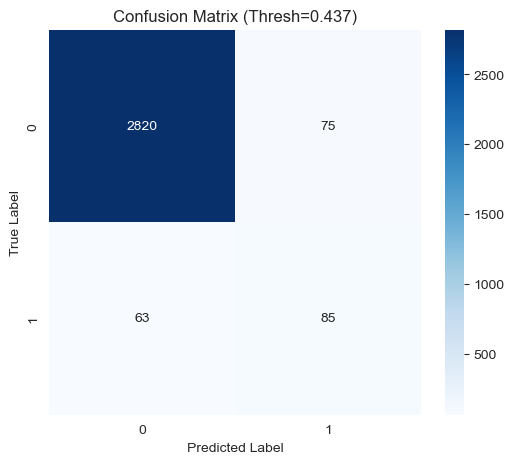


Top 20 Features quan trọng nhất (Gain):
feature
r_entropy            8105.869536
g_skew_Flux_dered    6081.829341
r_skew_Flux_dered    4858.996447
g_q10_Flux_dered     2848.024673
M_abs_u              2681.643196
det_duration_days    2492.192753
gr_med               2195.371863
r_pl_slope           1742.668635
r_mad_Flux_dered     1514.745642
decay_rate           1392.167828
Name: importance, dtype: float64


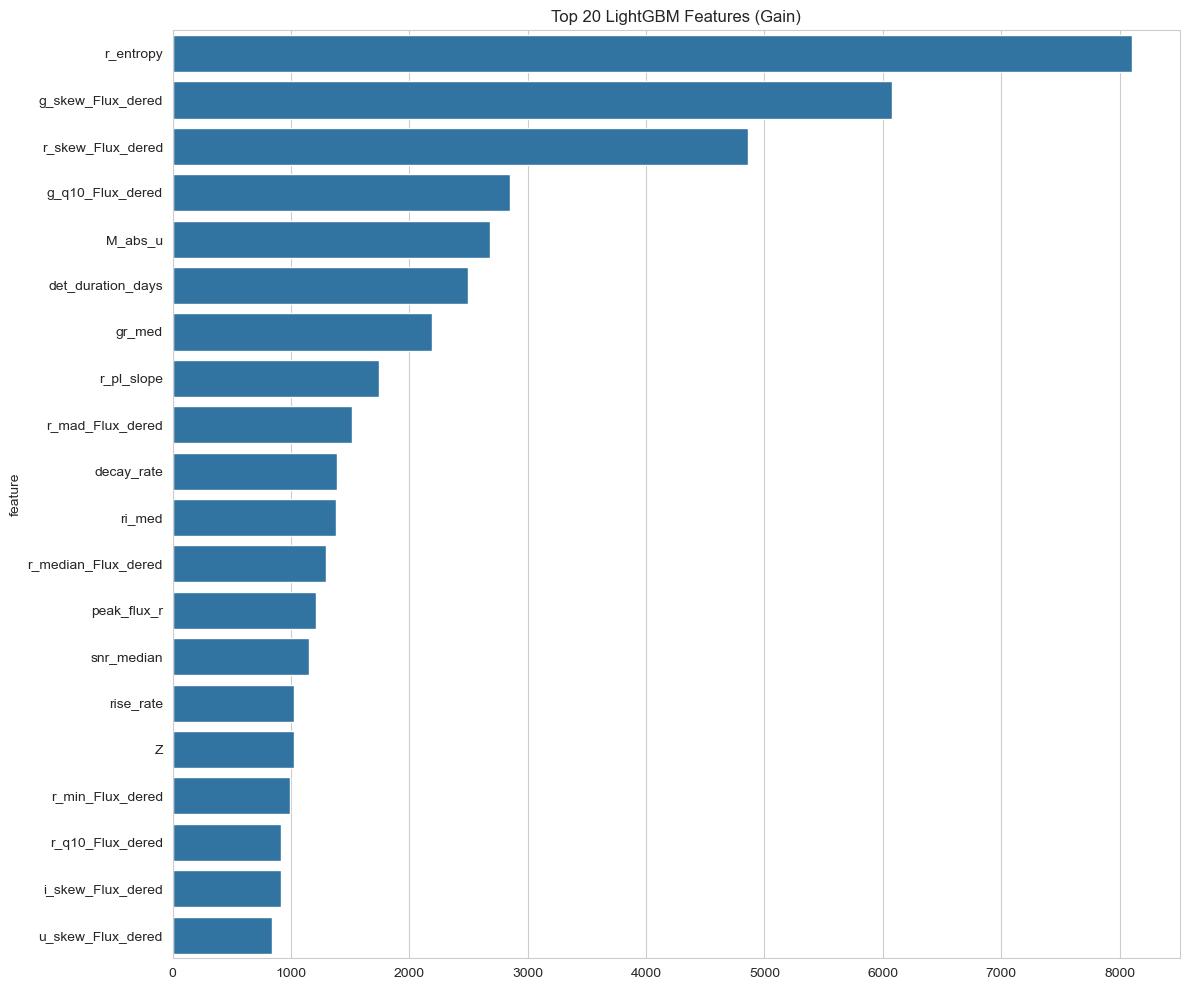


Saved submission to: models_out\submission.csv
Test Predicted TDEs: 372 objects


In [492]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
import os
import warnings
import gc

# Tắt cảnh báo rác
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# ===========================
# 1. CẤU HÌNH
# ===========================
class TrainConfig:
    # Đường dẫn đến file feature vừa tạo xong
    input_dir = "features_out"
    train_file = "train_features_all_splits.csv"
    test_file = "test_features_all_splits.csv"
    output_dir = "models_out"
    
    # Tham số LightGBM (Cân bằng giữa tốc độ và độ chính xác)
    lgb_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': 4769,         # Số lượng cây tối đa
        'learning_rate': 0.04799393568560562,        # Học chậm
        'num_leaves': 65,
        'max_depth': 5,
        'scale_pos_weight': 42.996243776757495,
        'min_child_samples': 84,
        'subsample': 0.610895108128813,             # Lấy mẫu dòng (tránh overfit)
        'colsample_bytree': 0.7335685491500781,      # Lấy mẫu cột
        'reg_alpha': 0.01611771036373666,             # Regularization L1
        'reg_lambda': 0.17625641265837544,            # Regularization L2
        'random_state': 42,
        'n_jobs': -1,
        'is_unbalance': False,         # QUAN TRỌNG: Tự động cân bằng class TDE/Non-TDE
        'verbosity': -1
    }
    
    n_folds = 5
    seed = 42

    #Best Params: {'n_estimators': 4769, 'learning_rate': 0.04799393568560562, 'num_leaves': 65, 'max_depth': 5, 'min_child_samples': 84, 'scale_pos_weight': 42.996243776757495, 'subsample': 0.610895108128813, 'colsample_bytree': 0.7335685491500781, 'reg_alpha': 0.01611771036373666, 'reg_lambda': 0.17625641265837544}

# ===========================
# 2. HÀM TÌM NGƯỠNG TỐI ƯU
# ===========================
def find_best_threshold(y_true, y_prob):
    """Tìm ngưỡng xác suất (p) để F1-Score cao nhất."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    # Tính F1 cho mọi ngưỡng
    f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
    
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    return best_threshold, best_f1

# ===========================
# 3. PIPELINE TRAINING
# ===========================
def train_pipeline(cfg):
    os.makedirs(cfg.output_dir, exist_ok=True)
    
    print("Loading final features...")
    train_df = pd.read_csv(os.path.join(cfg.input_dir, cfg.train_file))
    test_df = pd.read_csv(os.path.join(cfg.input_dir, cfg.test_file))
    
    # --- DANH SÁCH LOẠI TRỪ (CHỐNG LEAKAGE) ---
    ignore_cols = [
        'object_id', 'split', 'dataset', 'target', 
        'SpecType', 'type', 'class', 'target_id' # Loại bỏ hết các cột chứa đáp án
    ]
    
    features = [c for c in train_df.columns if c not in ignore_cols]
    target_col = 'target'
    
    print(f"\nTraining Config:")
    print(f"  Features: {len(features)}")
    print(f"  Train shape: {train_df.shape}")
    print(f"  Test shape:  {test_df.shape}")
    print(f"  TDE Count:   {train_df[target_col].sum()} / {len(train_df)}")
    
    # --- CHIẾN LƯỢC VALIDATION: GROUP K-FOLD (BẮT BUỘC) ---
    # Chia fold dựa trên object_id. 
    # Đảm bảo: Tất cả bản sao của Object A đều nằm chung 1 phe (hoặc Train, hoặc Val).
    gkf = GroupKFold(n_splits=cfg.n_folds)
    groups = train_df['object_id']
    
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    feature_importance_df = pd.DataFrame()
    
    print(f"\nStarting {cfg.n_folds}-Fold Training with GroupKFold...")
    
    for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, train_df[target_col], groups=groups)):
        # Lấy data theo index
        X_tr = train_df.iloc[train_idx][features]
        y_tr = train_df.iloc[train_idx][target_col]
        X_val = train_df.iloc[val_idx][features]
        y_val = train_df.iloc[val_idx][target_col]
        
        # Train LightGBM
        clf = lgb.LGBMClassifier(**cfg.lgb_params)
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=0) # Tắt log rác
        ]
        
        clf.fit(
            X_tr, y_tr,
            eval_set=[(X_tr, y_tr), (X_val, y_val)],
            eval_names=['train', 'valid'],
            eval_metric='auc',
            callbacks=callbacks
        )
        
        # Dự đoán
        val_prob = clf.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_prob
        
        # Dự đoán tập Test (Cộng dồn rồi chia trung bình)
        test_prob = clf.predict_proba(test_df[features])[:, 1]
        test_preds += test_prob / cfg.n_folds
        
        # Lưu Feature Importance
        fold_imp = pd.DataFrame()
        fold_imp["feature"] = features
        fold_imp["importance"] = clf.booster_.feature_importance(importance_type="gain")
        fold_imp["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_imp], axis=0)
        
        # Đánh giá Fold hiện tại
        score = roc_auc_score(y_val, val_prob)
        print(f"  Fold {fold+1}: AUC = {score:.4f} | Best Iter = {clf.best_iteration_}")
        
        # Dọn dẹp bộ nhớ
        del X_tr, y_tr, X_val, y_val, clf
        gc.collect()

    # ===========================
    # 4. ĐÁNH GIÁ & TỐI ƯU HÓA
    # ===========================
    print("\n" + "="*40)
    print("FINAL EVALUATION")
    print("="*40)
    
    # 1. AUC Tổng thể
    overall_auc = roc_auc_score(train_df[target_col], oof_preds)
    print(f"Overall CV AUC: {overall_auc:.5f}")
    
    # 2. Tìm Ngưỡng Tối Ưu (Best Threshold)
    best_thresh, best_f1 = find_best_threshold(train_df[target_col], oof_preds)
    print(f"Best Threshold: {best_thresh:.4f}")
    print(f"Max F1-Score:   {best_f1:.4f}")
    
    # 3. Confusion Matrix
    y_pred_binary = (oof_preds >= best_thresh).astype(int)
    cm = confusion_matrix(train_df[target_col], y_pred_binary)
    
    print("\nConfusion Matrix (at Best Threshold):")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(train_df[target_col], y_pred_binary))
    
    # Vẽ Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Thresh={best_thresh:.3f})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ===========================
    # 5. KIỂM TRA GIẢ THUYẾT VẬT LÝ
    # ===========================
    print("\nTop 20 Features quan trọng nhất (Gain):")
    avg_importance = (feature_importance_df.groupby("feature")["importance"]
                      .mean()
                      .sort_values(ascending=False))
    
    print(avg_importance.head(10))
    
    plt.figure(figsize=(12, 10))
    sns.barplot(x=avg_importance.head(20).values, y=avg_importance.head(20).index)
    plt.title('Top 20 LightGBM Features (Gain)')
    plt.tight_layout()
    plt.show()
    
    # ===========================
    # 6. XUẤT KẾT QUẢ SUBMISSION
    # ===========================
    # Gom nhóm kết quả Test theo object_id (vì 1 object có nhiều bản copy ở test)
    # Lấy trung bình xác suất của tất cả các split
    test_df['pred_prob'] = test_preds
    final_submission = test_df.groupby('object_id')['pred_prob'].mean().reset_index()
    
    # Áp dụng ngưỡng
    final_submission['predicted_class'] = (final_submission['pred_prob'] >= best_thresh).astype(int)
    
    sub_path = os.path.join(cfg.output_dir, "submission.csv")
    final_submission.to_csv(sub_path, index=False)
    
    print(f"\nSaved submission to: {sub_path}")
    print(f"Test Predicted TDEs: {final_submission['predicted_class'].sum()} objects")

if __name__ == "__main__":
    train_pipeline(TrainConfig)